# Traits models initial run

A first pass fitting a few different sklearn classifiers to the T2D and Lipids datasets. Though some initial preprocessing is conducted on the data no feature selection is performed at this stage. It should be noted that this notebook is meant to show an exploratory look into out of the box model performance. It should be noted that as there are currently more features than samples in the datasets (2750 features vs ~2100 samples), there aren't enough degrees of freedom to optimally fit an interpretable linear model.

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import s3fs
import boto
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score
import warnings
from matplotlib import pyplot as plt
plt.style.use('ggplot')
warnings.filterwarnings(action='ignore')
import sklearn 
import jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='oceans16')
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from auth import access_key, secret_key
from Evaluator import Evaluator
import itertools

### Data Preprocessing

In [2]:
# Alter with lipids/t2d/other if needed
options = ["t2d", "lipids", "grouped"]
trait = options[2]

train_filepath = "S3://voightlab-data/{}/{}_train.csv".format(trait, trait)
test_filepath = "S3://voightlab-data/{}/{}_test.csv".format(trait, trait)

In [3]:
train_df = pd.read_csv(train_filepath, index_col=0)
test_df = pd.read_csv(test_filepath, index_col=0)
train_df.head()

,MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed,MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed,GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed,K562_ChIP-seq_CTCF_ENCFF002CEL.bed,K562_ChIP-seq_POLR2A_ENCFF002CET.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed,endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed,keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed,keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed,H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed,...,islet_pooled_H3K4me1_final.bed,islet_CTCF_intersectall.bed,islet_H3K27ac.bed,islet_pooled_H3K27ac.bed,islet_pooled_H3K4me3_peaks.broadPeak,snpcount,is_t2d,is_lipids,is_both,label
1804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,1,0,0,1
8603,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,1,0.002347,0,1,0,2
9643,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.002347,0,0,0,0
5414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.001173,0,0,0,0
9989,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.000000,1,1,0,3


In [4]:
# Create training and test splits, dropping labels and sample weights from training set
labels = ['label']
to_drop = ['is_t2d', 'is_lipids', 'is_both']

X_train = train_df.drop(labels + to_drop, axis=1)
y_train = train_df.loc[:, labels]

X_test = test_df.drop(labels + to_drop, axis=1)
y_test = test_df.loc[:, labels]

In [5]:
# Show counts of each class
y_train.iloc[:,0].value_counts()

0    4485
1     403
2     392
3     116
Name: label, dtype: int64

In [6]:
# Init class for model evaluation - detailed in Evaluation.py
ev = Evaluator()

### Logistic Regression 

Sklearn's logistic regression model, with ten fold cross validation. Using the following parameters:
* cv = 10
* penalty = L1 (Same as lasso regression)
* class_weight = balanced (Sets regularization term C to 1/(class frequency) for each sample. Useful for imbalanced datasets. 

In [7]:
log_model = LogisticRegressionCV(solver='liblinear', 
                                 penalty='l1', 
                                 class_weight='balanced',
                                 scoring='roc_auc', 
                                 cv=10,
                                 max_iter=5000)
log_model.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight='balanced', cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=5000,
           multi_class='warn', n_jobs=None, penalty='l1',
           random_state=None, refit=True, scoring='roc_auc',
           solver='liblinear', tol=0.0001, verbose=0)

In [9]:
print("Training Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_train, y_train, threshold=0.5, average='micro')

Training Dataset Logistic Model Performance:
 Precision: 0.5782060785767235
 Recall: 0.5782060785767235
 Accuracy: 0.5782060785767235


In [13]:
print("Test Dataset Logistic", end=" ")
ev.summarize_performance(log_model, X_test, y_test, threshold=0.5, average='micro')

Test Dataset Logistic Model Performance:
 Precision: 0.4905450500556173
 Recall: 0.4905450500556173
 Accuracy: 0.4905450500556173


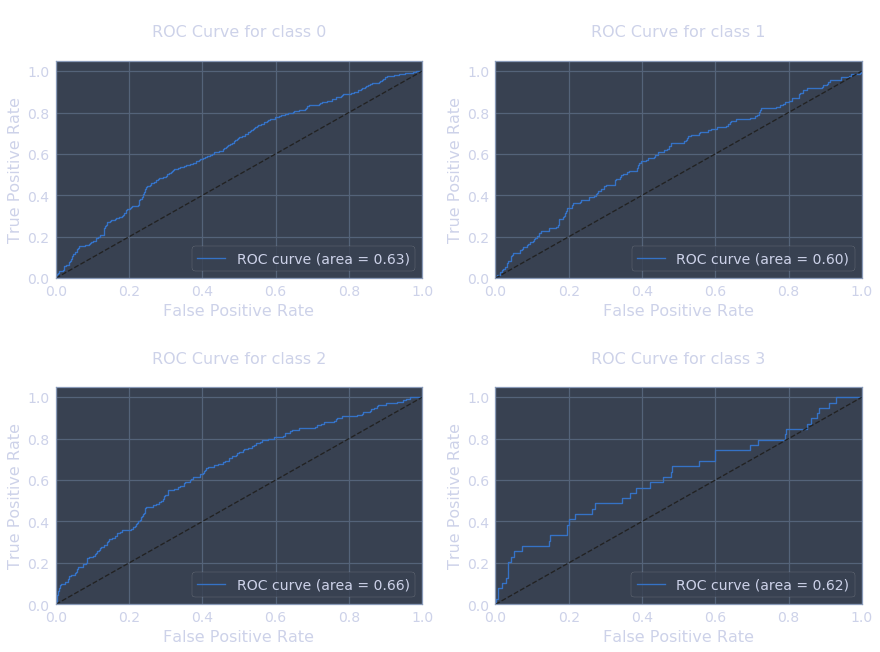

In [14]:
ev.plot_roc_curve(log_model,X_train, y_train, X_test, y_test, classes=[0,1,2,3])

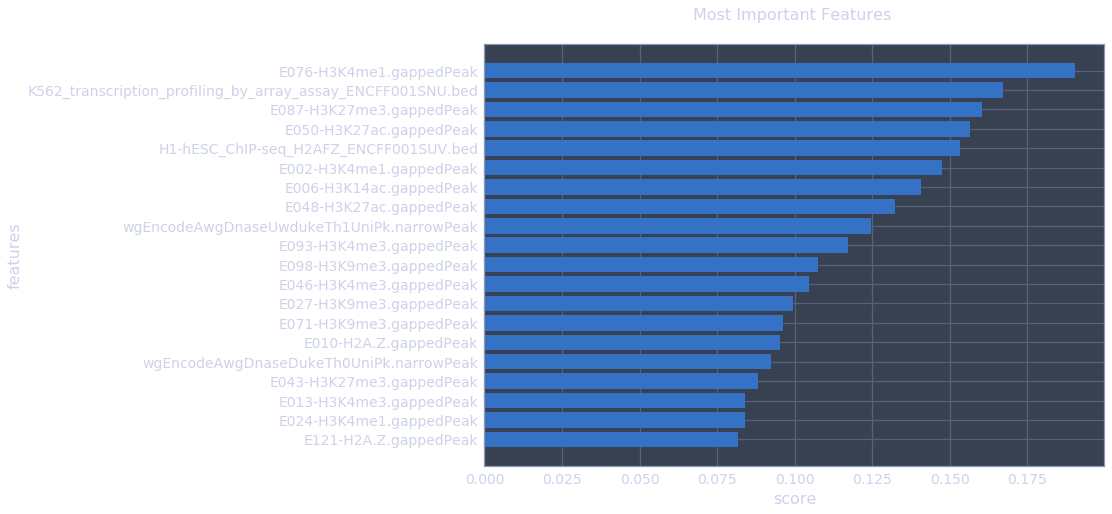

In [15]:
# Plot feature importance
coefs = log_model.coef_
feature_names = X_train.columns
important_features = ev.feat_importance(coefs, feature_names, 20, False)

# Random Forest

Sklearn's implementation of random forest with gridsearch. As mentioned, sklearn requires a one dimensional vector (e.g [1,2,3,4] for multiclass classification, though the random forest model can accept a multidimensional array e.g [[1,1,1], [1,0, 0]]. The second label type is for multilabel classification - i.e where samples can belong to more than one class. 

In [16]:
# n_jobs = -1 allows training to be done on all available cores
rf_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced')

# Parameter grid for grid search
rf_params = {'n_estimators': [100, 500, 1000, 2000],
			 'max_depth': [30, 100, 200]}

scoring = ['recall', 'roc_auc']

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3)

In [17]:
# Grid search to iteratively search parameter space
rf_grid = GridSearchCV(rf_model, param_grid=rf_params, cv=cv)
rf_grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f" % (rf_grid.best_params_, rf_grid.best_score_))

rf_grid_score = rf_grid.score(X_test, y_test)
print ("Grid search's score on new test data was {}".format(rf_grid_score))

The best parameters are {'max_depth': 30, 'n_estimators': 100} with a score of 0.83
Grid search's score on new test data was 0.8264738598442715


In [19]:
ev.summarize_performance(rf_grid, X_train, y_train, proba=False, average='micro')

Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [22]:
ev.summarize_performance(rf_grid.best_estimator_, X_test, y_test, proba=False, average='weighted')

Model Performance:
 Precision: 0.6830590410058884
 Recall: 0.8264738598442715
 Accuracy: 0.8264738598442715


In [23]:
top_n_features = 20

forest = rf_grid.best_estimator_
importances = rf_grid.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(top_n_features):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[f], importances[indices[f]]))

Feature ranking:
1. feature MCF-7_ChIP-seq_CTCF_ENCSR000AHD_ENCFF001UML_ENCFF001UMN_intersect.bed (0.004843)
2. feature MCF-7_ChIP-seq_TAF1_ENCSR000AHF_ENCFF001UNU_ENCFF001UNT_intersect.bed (0.001517)
3. feature GM12878_ChIP-seq_CTCF_ENCFF002CDP.bed (0.001508)
4. feature K562_ChIP-seq_CTCF_ENCFF002CEL.bed (0.001379)
5. feature K562_ChIP-seq_POLR2A_ENCFF002CET.bed (0.001363)
6. feature endothelial_cell_of_umbilical_vein_ChIP-seq_CTCF_ENCFF002CEH.bed (0.001324)
7. feature endothelial_cell_of_umbilical_vein_ChIP-seq_POLR2A_ENCFF002CEJ.bed (0.001307)
8. feature keratinocyte_ChIP-seq_CTCF_ENCFF002CFA.bed (0.001297)
9. feature keratinocyte_ChIP-seq_POLR2A_ENCFF002CFC.bed (0.001293)
10. feature H1-hESC_ChIP-seq_H3K27me3_ENCFF001SUY.bed (0.001285)
11. feature mammary_epithelial_cell_ChIP-seq_CTCF_ENCFF002CEB.bed (0.001283)
12. feature HepG2_ChIP-seq_CTCF_ENCFF002CDZ.bed (0.001258)
13. feature H1-hESC_ChIP-seq_CTCF_ENCFF002CDS.bed (0.001252)
14. feature H1-hESC_ChIP-seq_H3K4me3_ENCFF001SVC.bed 

In [ ]:

def plot_roc_curve(model, Xtrain, ytrain, Xtest, ytest, classes):
    ytrain = label_binarize(ytrain, classes=[0,1,2,3])
    ytest = label_binarize(ytest, classes=[0,1,2,3])
    n_classes=len(classes)

    clf = OneVsRestClassifier(model)

    # yscore = clf.fit(Xtrain, ytrain).decision_function(Xtest)
    clf.fit(Xtrain, ytrain)
    y_score = clf.predict_proba(Xtest)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Store number of rows and cols to create subplots
    nrows = round((len(classes)/2))
    ncols = 2

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(13, 9), dpi=80)
    fig.subplots_adjust(hspace=0.5)
    idx=0

    for r_ind,row in enumerate(ax):
        for c_ind, col in enumerate(row):
                col.plot(fpr[idx], tpr[idx], label='ROC curve (area = %0.2f)' % roc_auc[idx])
                col.plot([0, 1], [0, 1], 'k--')
                col.set_xlim([0.0, 1.0])
                col.set_ylim([0.0, 1.05])
                col.set_xlabel('False Positive Rate')
                col.set_ylabel('True Positive Rate')
                col.set_title("\n" + "ROC Curve for class " + str(idx) + "\n")
                col.legend(loc="lower right")
                idx+=1 

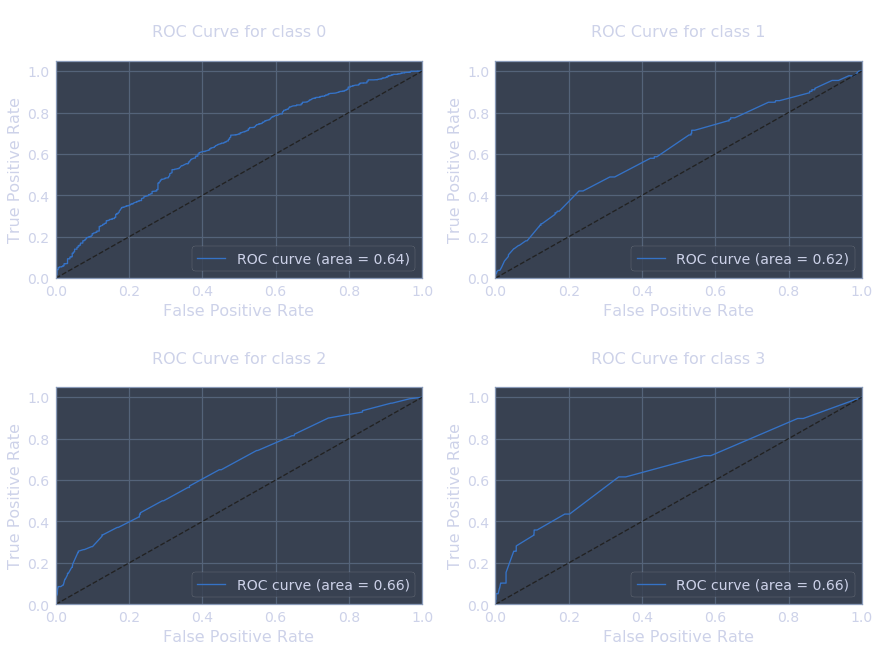

In [24]:
ev.plot_roc_curve(rf_grid, X_train, y_train, X_test, y_test, classes=[0,1,2,3])

### Support Vector Machine 

When used with a linear kernel still allows for evaluation of feature coefficients. Class weight parameter sets regularization parameter C for class i to n_samples / (n_classes * np.bincount(y)) 

In [25]:
svm_model = SVC(kernel='linear', class_weight='balanced', probability=True, max_iter=5000)
svm_model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=5000, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [27]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_train, y_train, average='micro', proba=False)

Training Dataset SVM Model Performance:
 Precision: 1.0
 Recall: 1.0
 Accuracy: 1.0


In [29]:
print("Training Dataset SVM", end=" ")
ev.summarize_performance(svm_model, X_test, y_test, average='micro', proba=False)

Training Dataset SVM Model Performance:
 Precision: 0.7324805339265851
 Recall: 0.7324805339265851
 Accuracy: 0.7324805339265851


In [30]:
ev.plot_roc_curve(svm_model, X_train, y_train, X_test, y_test, classes=[0,1,2,3])

KeyboardInterrupt: 

In [ ]:
# Plot feature importance
coefs = svm_model.coef_
feature_names = X_train.columns
important features = ev.feat_importance(coefs, feature_names, 20, one_dim=False)